## Final Modelling - XGBoost

### Import Libraries

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

### Import Data

In [2]:
df = pd.read_csv('risk_factors_cervical_cancer.csv')

In [3]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


### Upsampling Positive Class

In [4]:
df_majority = df[(df['Biopsy']==0)] 
df_minority = df[(df['Biopsy']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 800, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

### Dealing with '?' Responses

In [5]:
# Replace the '?' with None type
df_upsampled.replace({'?':None}, inplace=True)
df = df_upsampled.fillna(value=np.nan)

In [6]:
df.shape

(1603, 36)

### Defining X & y 

In [7]:
# indicators of cervical cancer, biopsy is the chosen method
indicators = ['Biopsy', 'Citology','Hinselmann', 'Schiller']
y = df[indicators]
X = df.drop(columns = indicators)

In [8]:
y = y.astype(int)

In [9]:
# Renaming columns and turning it into a dataframe
def x_df(X):
    
    X_df = pd.DataFrame(X)
    X_df = X_df.astype({0: float,
               1: float,
               2: float,
               3: float,
               4: bool,
               5: float,
               6: float,
               7: bool,
               8: float,
               9: bool,
               10: float,
               11: bool,
               12: float,
               13: bool,
               14: bool,
               15: bool,
               16: bool,
               17: bool,
               18: bool,
               19: bool,
               20: bool,
               21: bool,
               22: bool,
               23: bool,
               24: bool,
               25: float,
               26: float,
               27: float,
               28: bool,
               29: bool,
               30: bool,
               31: bool}
         )
    column_list = {0: "Age",
                   1: "Number of sexual partners",
                   2: "First sexual intercourse (age)",
                   3: "Num of pregnancies",
                   4: "Smokes",
                   5: "Smokes (years)",
                   6: "Smokes (packs/year)",
                   7: "Hormonal Contraceptives",
                   8: "Hormonal Contraceptives (years)",
                   9: "IUD",
                   10: "IUD (years)",
                   11: "STDs",
                   12: "STDs (number)",
                   13: "STDs:condylomatosis",
                   14: "STDs:cervical condylomatosis",
                   15: "STDs:vaginal condylomatosis",
                   16: "STDs:vulvo-perineal condylomatosis",
                   17: "STDs:syphilis",
                   18: "STDs:pelvic inflammatory disease",
                   19: "STDs:genital herpes",
                   20: "STDs:molluscum contagiosum",
                   21: "STDs:AIDS",
                   22: "STDs:HIV",
                   23: "STDs:Hepatitis B",
                   24: "STDs:HPV",
                   25: "STDs: Number of diagnosis",
                   26: "STDs: Time since first diagnosis",
                   27: "STDs: Time since last diagnosis",
                   28: "Dx:Cancer",
                   29: "Dx:CIN",
                   30: "Dx:HPV",
                   31: "Dx"}

    X_df = X_df.rename(columns=column_list, errors="raise")
    return X_df

### Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Biopsy'], test_size=0.20, stratify =y['Biopsy'], random_state=42)

### Impute Data using KNN

In [11]:
imputer = KNNImputer(n_neighbors = 8)
imputer.fit(X_train)
X_train_im = x_df(imputer.transform(X_train))
X_test_im = x_df(imputer.transform(X_test))

In [12]:
# Save the imputer
pickle.dump(imputer, open('imputer.pkl', 'wb'))

### Scale Data

In [13]:
scaler = RobustScaler()
X_train_rs = scaler.fit(X_train_im)
X_train_rs = x_df(scaler.transform(X_train_im))
X_test_rs = x_df(scaler.transform(X_test_im))

In [14]:
# Save the scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

### RandomSearch

In [85]:
params = {'max_depth': [3,4], # more shallow to reduce overfitting
          'learning_rate': [0.05,0.1], #slower learning rates
          'n_estimators' : [50, 100, 300, 500],
          'colsample_bytree' : [0.5, 0.7], #lower col sample to reduce overfitting
          'subsample' : [0.4, 0.6, 0.8],
          'gamma' : [0.5, 0.7, 0.9], #larger gamma to reduce overfitting
          'booster' : ['gbtree','gblinear','dart'],
             }

In [86]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', n_jobs=-1,random_state=42)

In [87]:
clf = RandomizedSearchCV(estimator=xgb,
                         param_distributions=params,
                         scoring='f1_micro',
                         n_iter=25,
                         verbose=1,
                         n_jobs = -1,
                        cv = 3)

In [88]:
clf.fit(X=X_train_rs, y=y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
                                    

In [89]:
clf.best_params_

{'subsample': 0.8,
 'n_estimators': 500,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0.9,
 'colsample_bytree': 0.7,
 'booster': 'gbtree'}

In [90]:
preds = clf.predict(X_test_rs)

In [91]:
print(f"Test Accuracy: {accuracy_score(y_test, preds)}")

Test Accuracy: 0.9719626168224299


In [92]:
print(f"F1 Score: {f1_score(y_test, preds)}")

F1 Score: 0.9726443768996961


### Model Training

In [107]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', n_jobs=-1,random_state=42,
          max_depth= 4,
          learning_rate= 0.05,
          n_estimators= 500,
          colsample_bytree=  0.7,
          subsample= 0.8,
          gamma= 0.9,
          booster= 'gbtree')

In [108]:
xgb.fit(X_train_rs, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='logloss', gamma=0.9,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [109]:
y['Biopsy'].value_counts(normalize=True) #Baseline scores

0    0.500936
1    0.499064
Name: Biopsy, dtype: float64

In [110]:
xgb.score(X_train_rs, y_train)

0.9929797191887676

In [111]:
xgb.score(X_train_rs, y_train)

0.9929797191887676

In [112]:
preds = xgb.predict(X_test_rs)

In [113]:
f1_score(y_test, preds)

0.9696969696969697

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


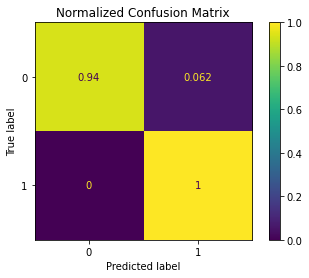

In [114]:
plot_confusion_matrix(xgb, X_test_rs, y_test, normalize='true') 
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()

### Final Model 

In [115]:
# Train on the full dataset
X_im = x_df(imputer.transform(X))
X_rs = x_df(scaler.transform(X_im))
xgb.fit(X_rs, y['Biopsy'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='logloss', gamma=0.9,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [116]:
xgb.score(X_rs, y['Biopsy'])

0.9925140361821585

In [117]:
preds = xgb.predict(X_rs)

In [118]:
f1_score(y['Biopsy'], preds)

0.9925558312655086

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


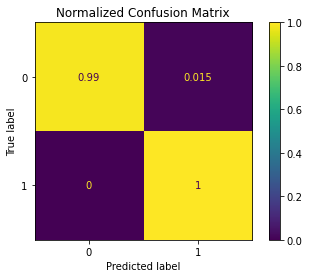

In [119]:
plot_confusion_matrix(xgb, X_rs, y['Biopsy'], normalize='true') 
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()

In [121]:
# Save model
filename = 'cervical_cancer_risk_model.sav'
pickle.dump(xgb, open(filename, 'wb'))